# Evaluating Contrastive Embedding

In [8]:
import os
import time
import pickle
import random

import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.nn import functional as F

from quadrotor_diffusion.utils.dataset.normalizer import NormalizerTuple
from quadrotor_diffusion.utils.file import get_checkpoint_file
from quadrotor_diffusion.utils.nn.training import Trainer
from quadrotor_diffusion.models.vae_wrapper import VAE_Wrapper
from quadrotor_diffusion.models.latent_classifier_wrapper import LatentClassifierWrapper
from quadrotor_diffusion.utils.dataset.boundary_condition import PolynomialTrajectory

from quadrotor_diffusion.utils.plotting import course_base_plot, add_gates_to_course

In [66]:
course_types = ["u", "linear"]
data_dir = "../data"

data = dict()

for course_type in course_types:
    data[course_type] = dict()
    course_dir = os.path.join(data_dir, "courses", course_type)
    for sample in os.listdir(course_dir):
        sample_dir = os.path.join(course_dir, sample)
        if not os.path.isdir(sample_dir):
            continue

        course_filename = os.path.join(sample_dir, "course.npy")
        if not os.path.exists(course_filename):
            continue
        data[course_type][course_filename] = list()
        # Find valid trajectories
        valid_dir = os.path.join(sample_dir, "valid")
        if os.path.exists(valid_dir):
            for valid_file in os.listdir(valid_dir):
                if valid_file.endswith(".pkl"):
                    traj_filename = os.path.join(valid_dir, valid_file)

                    # 1 for valid trajectory
                    data[course_type][course_filename].append(traj_filename)

In [6]:
model: LatentClassifierWrapper = None
normalizer: NormalizerTuple = None

chkpt = get_checkpoint_file("../logs/training", 138)
model, _, normalizer, _ = Trainer.load(chkpt, get_ema=False)
model = model.cuda()

traj_encoder: VAE_Wrapper = None
chkpt = get_checkpoint_file("../logs/training", 102)
traj_encoder, _, normalizer, _ = Trainer.load(chkpt, get_ema=False)
traj_encoder = traj_encoder.cuda()

print(chkpt)

../logs/training/102.VAE_Wrapper.Feb.11_01:50_AM/checkpoints/epoch_119_loss_0.0486


In [7]:
N = 20

In [21]:
linear = list(set([random.choice(list(data["linear"].keys())) for _ in range(N)]))
u = list(set([random.choice(list(data["u"].keys())) for _ in range(N)]))

In [62]:
def operate(courses, courses_b, data_b) -> torch.Tensor:
    matching_scores = []
    mismatching_scores = []
    
    for course_a in tqdm.tqdm(courses):
        course = np.load(course_a)
        course = torch.tensor(course, dtype=torch.float32).cuda().unsqueeze(0)
        course = course[..., :3]
        
        for course_b in courses_b:
            match = course_a == course_b
            
            trajectories = []
            for traj_filename in data_b[course_b]:
                assert traj_filename.endswith(".pkl")
                
                with open(traj_filename, "rb") as file:
                    trajectory: PolynomialTrajectory = pickle.load(file)
                
                trajectory = trajectory.as_ref_pos(pad_to=384)
                trajectory = torch.tensor(trajectory, dtype=torch.float32).cuda().unsqueeze(0)
                trajectories.append(trajectory)
            
            trajectories = torch.concat(trajectories)
            traj_z = traj_encoder.encode(trajectories)[0]
            course = course.expand(traj_z.shape[0], -1, -1)
            scores = model.compute_probability(traj_z, course).detach().cpu().numpy()
            course = course[0]
            
            if match:
                matching_scores.append(scores)
            else:
                mismatching_scores.append(scores)
            
    return np.concatenate(matching_scores), np.concatenate(mismatching_scores)

In [67]:
matching_scores, mismatching_scores = operate(linear, linear, data["linear"])

100%|██████████| 20/20 [02:10<00:00,  6.51s/it]


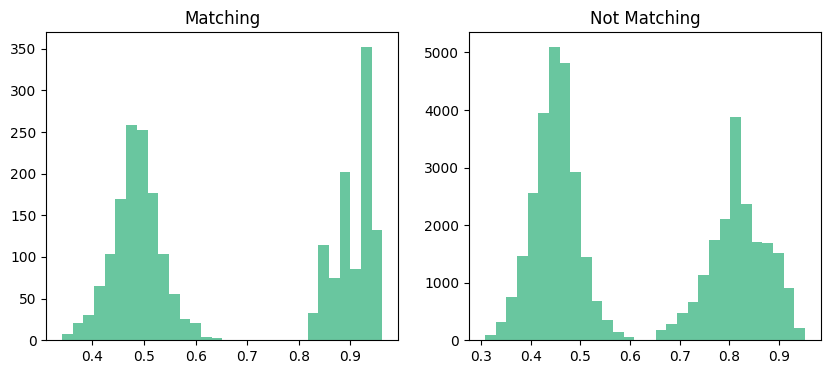

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(matching_scores, bins=30)
axes[0].set_title("Matching")
axes[1].hist(mismatching_scores, bins=30)
axes[1].set_title("Not Matching")
plt.show()

In [79]:
matching_scores, mismatching_scores = operate(u, u, data["u"])

100%|██████████| 20/20 [01:32<00:00,  4.65s/it]


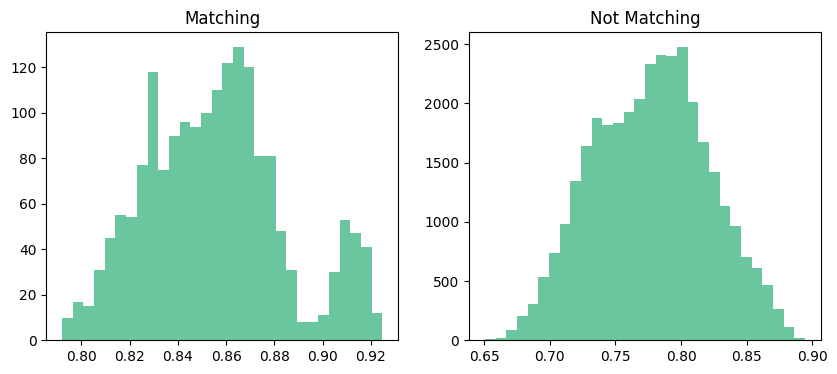

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(matching_scores, bins=30)
axes[0].set_title("Matching")
axes[1].hist(mismatching_scores, bins=30)
axes[1].set_title("Not Matching")
plt.show()